In [1]:
import os
from typing import Union, Optional

import torch.cuda
from torch.backends import cudnn

from nnunetv2.run.run_training import get_trainer_from_args, maybe_load_checkpoint

pretrained = os.path.join(os.environ['nnUNet_results'], 'Dataset213_ONKOI-all-from-208/nnUNetTrainer_noMirroringAxis2redRot__nnUNetPlans__3d_fullres_separatenormV2/fold_0/checkpoint_best.pth')


dataset_name_or_id: Union[str, int] = '213'
configuration: str = '3d_fullres_separatenormV2'
fold: Union[int, str] = 0
trainer_class_name: str = 'nnUNetTrainer_noMirroringAxis2redRot'
plans_identifier: str = 'nnUNetPlans'
pretrained_weights: Optional[str] = pretrained
num_gpus: int = 1
use_compressed_data: bool = False
export_validation_probabilities: bool = False
continue_training: bool = False
only_run_validation: bool = False
disable_checkpointing: bool = False
device: torch.device = torch.device('cuda')
num_epochs: int = 1000

if isinstance(fold, str):
    if fold != 'all':
        try:
            fold = int(fold)
        except ValueError as e:
            print(f'Unable to convert given value for fold to int: {fold}. fold must bei either "all" or an integer!')
            raise e

nnunet_trainer = get_trainer_from_args(dataset_name_or_id, configuration, fold, trainer_class_name,
                                        plans_identifier, use_compressed_data, device=device, num_epochs=num_epochs)

if disable_checkpointing:
    nnunet_trainer.disable_checkpointing = disable_checkpointing

assert not (continue_training and only_run_validation), f'Cannot set --c and --val flag at the same time. Dummy.'

maybe_load_checkpoint(nnunet_trainer, continue_training, only_run_validation, pretrained_weights)

if torch.cuda.is_available():
    cudnn.deterministic = False
    cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Number of trainable/total parameters in M: 30.78/30.78
################### Loading pretrained weights from file  /storage/nnUnet/nnUNet_trained_models/Dataset213_ONKOI-all-from-208/nnUNetTrainer_noMirroringAxis2redRot__nnUNetPlans__3d_fullres_separatenormV2/fold_0/checkpoint_best.pth ###################
Below is the list of overlapping blocks in pretrained model and nnUNet architecture:
encoder.stages.0.module_list.0.convs.module_list.0.conv.weight shape torch.Size([32, 1, 1, 3, 3])
encoder.stages.0.module_list.0.convs.module_list.0.conv.bias shape torch.Size([32])
enco

In [2]:
# from torchvision.models.feature_extraction import create_feature_extractor
# from torchvision.models.feature_extraction import get_graph_node_names
# get_graph_node_names(nnunet_trainer.network)

In [3]:
import numpy as np
nnunet_trainer.on_train_start()
nnunet_trainer.on_validation_epoch_start()
# data = next(nnunet_trainer.dataloader_val)

fn = '/media/medical/gasperp/projects/nnUnetv2_clone/nnUNet/nnunetv2/inference/test_patch.npz'
# with open(fn, 'wb') as f:
#     np.savez(f, data=data['data'].cpu().numpy(), target=data['target'][0].cpu().numpy())
ddd = np.load(fn)
data = {'data': torch.from_numpy(ddd['data']), 'target': [torch.from_numpy(ddd['target'])]}


This is the configuration used by this training:
Configuration name: 3d_fullres_separatenormV2
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [40, 192, 224], 'median_image_size_in_voxels': [94.0, 459.5, 466.0], 'spacing': [2.0, 0.5, 0.5], 'normalization_schemes': ['CTNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False], 'UNet_class_name': 'PlainConvUNetSeparateNormV2', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2], 'num_pool_per_axis': [3, 5, 5], 'pool_op_kernel_sizes': [[1, 1, 1], [1, 2, 2], [1, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], 'conv_kernel_sizes': [[1, 3, 3], [1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 'unet_max_num_features': 320, 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order'

In [24]:
nnunet_trainer.network.encoder.stages[0][0].convs[1].norm[1]

InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)

In [25]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                activation[name] = [o.detach().cpu().numpy() for o in output]
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []

    for stage in range(5):
        hooks.append(nnunet_trainer.network.encoder.stages[stage][0].convs[1].norm[0].register_forward_hook(get_activation(f'skip{stage}_CT')))
        hooks.append(nnunet_trainer.network.encoder.stages[stage][0].convs[1].norm[1].register_forward_hook(get_activation(f'skip{stage}_MR')))
    

    hooks.append(nnunet_trainer.network.decoder.stages[0].convs[1].nonlin.register_forward_hook(get_activation('decoder0')))
    hooks.append(nnunet_trainer.network.decoder.stages[1].convs[1].nonlin.register_forward_hook(get_activation('decoder1')))
    hooks.append(nnunet_trainer.network.decoder.stages[2].convs[1].nonlin.register_forward_hook(get_activation('decoder2')))
    hooks.append(nnunet_trainer.network.decoder.stages[3].convs[1].nonlin.register_forward_hook(get_activation('decoder3')))
    hooks.append(nnunet_trainer.network.decoder.stages[4].convs[1].nonlin.register_forward_hook(get_activation('decoder4')))
    hooks.append(nnunet_trainer.network.decoder.seg_layers[4].register_forward_hook(get_activation('pred_seg')))


    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
"""
nnunet_trainer.network.encoder.stages 0-5
each stage in encoder has two branches: CT and MR 0-1
each branch has a single StackedConvBlocks (double-conv) block, so 0
"""

d = data['data'][[0]].to('cuda:0')
activation = setup_hooks(d)

In [27]:
for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

skip0_CT (1, 32, 40, 192, 224)
skip0_MR (1, 32, 40, 192, 224)
skip1_CT (1, 64, 40, 96, 112)
skip1_MR (1, 64, 40, 96, 112)
skip2_CT (1, 128, 40, 48, 56)
skip2_MR (1, 128, 40, 48, 56)
skip3_CT (1, 256, 20, 24, 28)
skip3_MR (1, 256, 20, 24, 28)
skip4_CT (1, 320, 10, 12, 14)
skip4_MR (1, 320, 10, 12, 14)
decoder0 (1, 320, 10, 12, 14)
decoder1 (1, 256, 20, 24, 28)
decoder2 (1, 128, 40, 48, 56)
decoder3 (1, 64, 40, 96, 112)
decoder4 (1, 32, 40, 192, 224)
pred_seg (1, 31, 40, 192, 224)


In [28]:
[i.shape for i in data['target']]

[torch.Size([2, 1, 40, 192, 224])]

In [29]:
# write me a function to plot activation maps in two rows, 1. row should be the max projection, 2. row should be the mean projection
# the function should take the activation dict and the name of the layer as input

def plot(activation, t, B, SLC, img):
    fig, axes = plt.subplots(3, len(activation)+2, figsize=(18, 6))

    for i, key in enumerate(activation.keys()):
        if key == 'pred_seg':
            FM = activation[key][B][1:]
        else:
            FM = activation[key][B]
        axes[0,i].imshow(FM.max(0)[SLC], cmap='gray')
        axes[1,i].imshow(FM.mean(0)[SLC], cmap='gray')
        axes[2,i].imshow(FM.std(0)[SLC], cmap='gray')
        axes[0,i].set_title(key)
        
    axes[0,0].set_ylabel('max')
    axes[1,0].set_ylabel('mean')
    axes[2,0].set_ylabel('std')

    axes[0,-2].imshow(t[SLC], cmap='gray')
    axes[1,-2].imshow(t[SLC], cmap='gray')
    axes[2,-2].imshow(t[SLC], cmap='gray')
    
    axes[0,-1].imshow(img[SLC], cmap='gray')
    axes[1,-1].imshow(img[SLC], cmap='gray')
    axes[2,-1].imshow(img[SLC], cmap='gray')
    plt.tight_layout()
    plt.show()

In [30]:
d.shape

torch.Size([1, 2, 40, 192, 224])

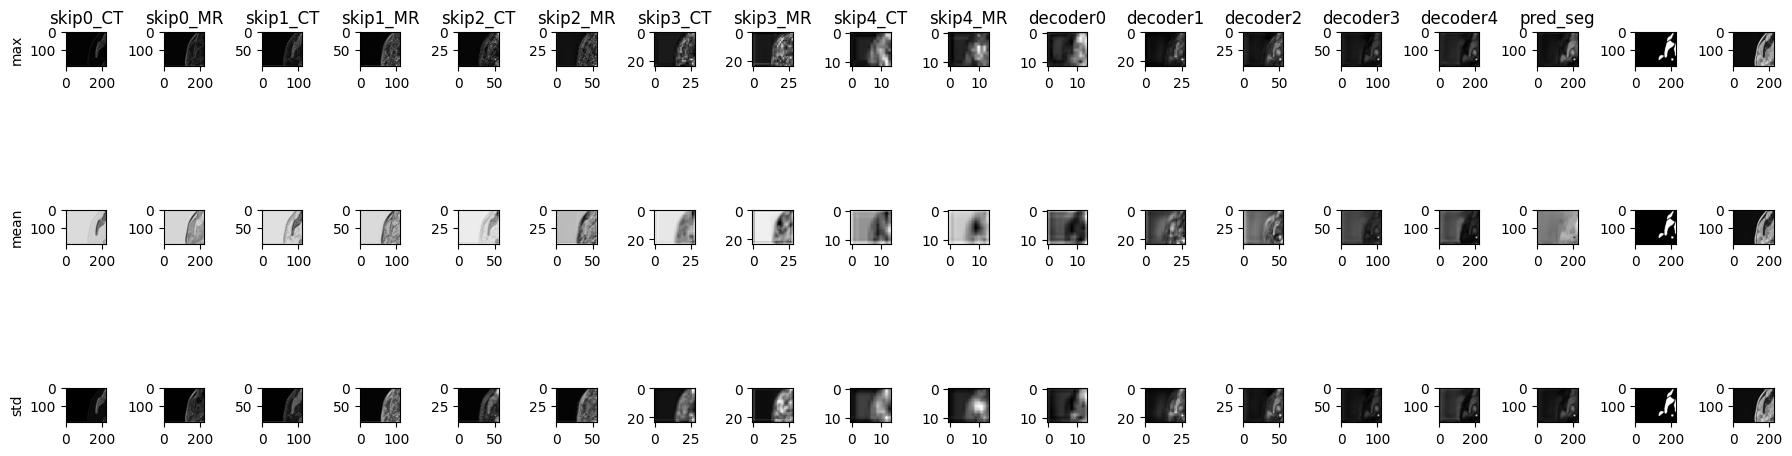

In [31]:
B = 0
SLC = 0

t = data['target'][0][B][0].cpu().numpy().astype(bool).astype(int)

plot(activation, t, B, SLC, d[0][1].cpu().numpy())